# Algoritmos de Inteligência Artificial para clusterização [25E4_2]


## Github: https://github.com/brunoblda/25E4_2_clusterizacao_de_dados

## Inicialização das bibliotecas

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import json
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Ler o arquivo kaggle.json do diretório do projeto
kaggle_json_path = os.path.join(os.getcwd(), ".kaggle", "kaggle.json")
with open(kaggle_json_path, 'r') as f:
    kaggle_config = json.load(f)

# Setar as variáveis de ambiente para autenticação do Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Inicializar e autenticar a API do Kaggle
api = KaggleApi()
api.authenticate()

print("Autenticação no Kaggle realizada com sucesso!")

Autenticação no Kaggle realizada com sucesso!


## Baixando o Dataset

In [119]:
# Baixar o dataset
api.dataset_download_files('rohan0301/unsupervised-learning-on-country-data', path='./datasets', unzip=True)
print("Dataset baixado com sucesso!")

Dataset URL: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data
Dataset baixado com sucesso!


## Carregando os dados

In [120]:

dados_originais = pd.read_csv('./datasets/Country-data.csv')
descricao_colunas = pd.read_csv('./datasets/data-dictionary.csv')

## Análise Exploratória do Dataset

In [121]:
# Análise Exploratória dos Dados
print("Análise Exploratória dos Dados")

for linha in descricao_colunas.values:
    print(f"{linha[0]:<12} - {linha[1]}")

print("="*75)

info = dados_originais.info()

print("="*75)

if dados_originais['country'].nunique() == len(dados_originais):
    paises = dados_originais['country'].tolist()
    print()
    print("Países no dataset:", paises)
    print()
    print("="*75)
    print()
    print("Quantidade de países no dataset:", len(paises))
    print()

print("="*75)

describe = dados_originais.describe()
print("descrição estatística do dataset:\n", describe)

print("="*75)

head = dados_originais.head()
print("5 primeiras linhas do dataset:\n", head)

print("="*75)


Análise Exploratória dos Dados
country      - Name of the country
child_mort   - Death of children under 5 years of age per 1000 live births
exports      - Exports of goods and services per capita. Given as %age of the GDP per capita
health       - Total health spending per capita. Given as %age of GDP per capita
imports      - Imports of goods and services per capita. Given as %age of the GDP per capita
Income       - Net income per person
Inflation    - The measurement of the annual growth rate of the Total GDP
life_expec   - The average number of years a new born child would live if the current mortality patterns are to remain the same
total_fer    - The number of children that would be born to each woman if the current age-fertility rates remain the same.
gdpp         - The GDP per capita. Calculated as the Total GDP divided by the total population.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Cou

# Análise da Faixa Dinâmica das Variáveis para Clusterização

Criação de gráficos que mostram a distribuição e escala dos dados

In [122]:
# Configurar o estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

# Separar apenas as colunas numéricas (excluindo 'country')
dados_numericos = dados_originais.select_dtypes(include=[np.number])
print(f"Variáveis numéricas disponíveis: {list(dados_numericos.columns)}")
print(f"Dimensões dos dados numéricos: {dados_numericos.shape}")

Variáveis numéricas disponíveis: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
Dimensões dos dados numéricos: (167, 9)


In [123]:
# Análise das escalas das variáveis
print("ANÁLISE DAS ESCALAS DAS VARIÁVEIS:")
print("-"*75)
for col in dados_numericos.columns:
    min_val = dados_numericos[col].min()
    max_val = dados_numericos[col].max()
    mean_val = dados_numericos[col].mean()
    std_val = dados_numericos[col].std()
    
    print(f"{col:15} | Min: {min_val:10.2f} | Max: {max_val:10.2f} | Média: {mean_val:10.2f} | Desvio: {std_val:10.2f}")

print("\n" + "-"*75)

ANÁLISE DAS ESCALAS DAS VARIÁVEIS:
---------------------------------------------------------------------------
child_mort      | Min:       2.60 | Max:     208.00 | Média:      38.27 | Desvio:      40.33
exports         | Min:       0.11 | Max:     200.00 | Média:      41.11 | Desvio:      27.41
health          | Min:       1.81 | Max:      17.90 | Média:       6.82 | Desvio:       2.75
imports         | Min:       0.07 | Max:     174.00 | Média:      46.89 | Desvio:      24.21
income          | Min:     609.00 | Max:  125000.00 | Média:   17144.69 | Desvio:   19278.07
inflation       | Min:      -4.21 | Max:     104.00 | Média:       7.78 | Desvio:      10.57
life_expec      | Min:      32.10 | Max:      82.80 | Média:      70.56 | Desvio:       8.89
total_fer       | Min:       1.15 | Max:       7.49 | Média:       2.95 | Desvio:       1.51
gdpp            | Min:     231.00 | Max:  105000.00 | Média:   12964.16 | Desvio:   18328.70

---------------------------------------------------

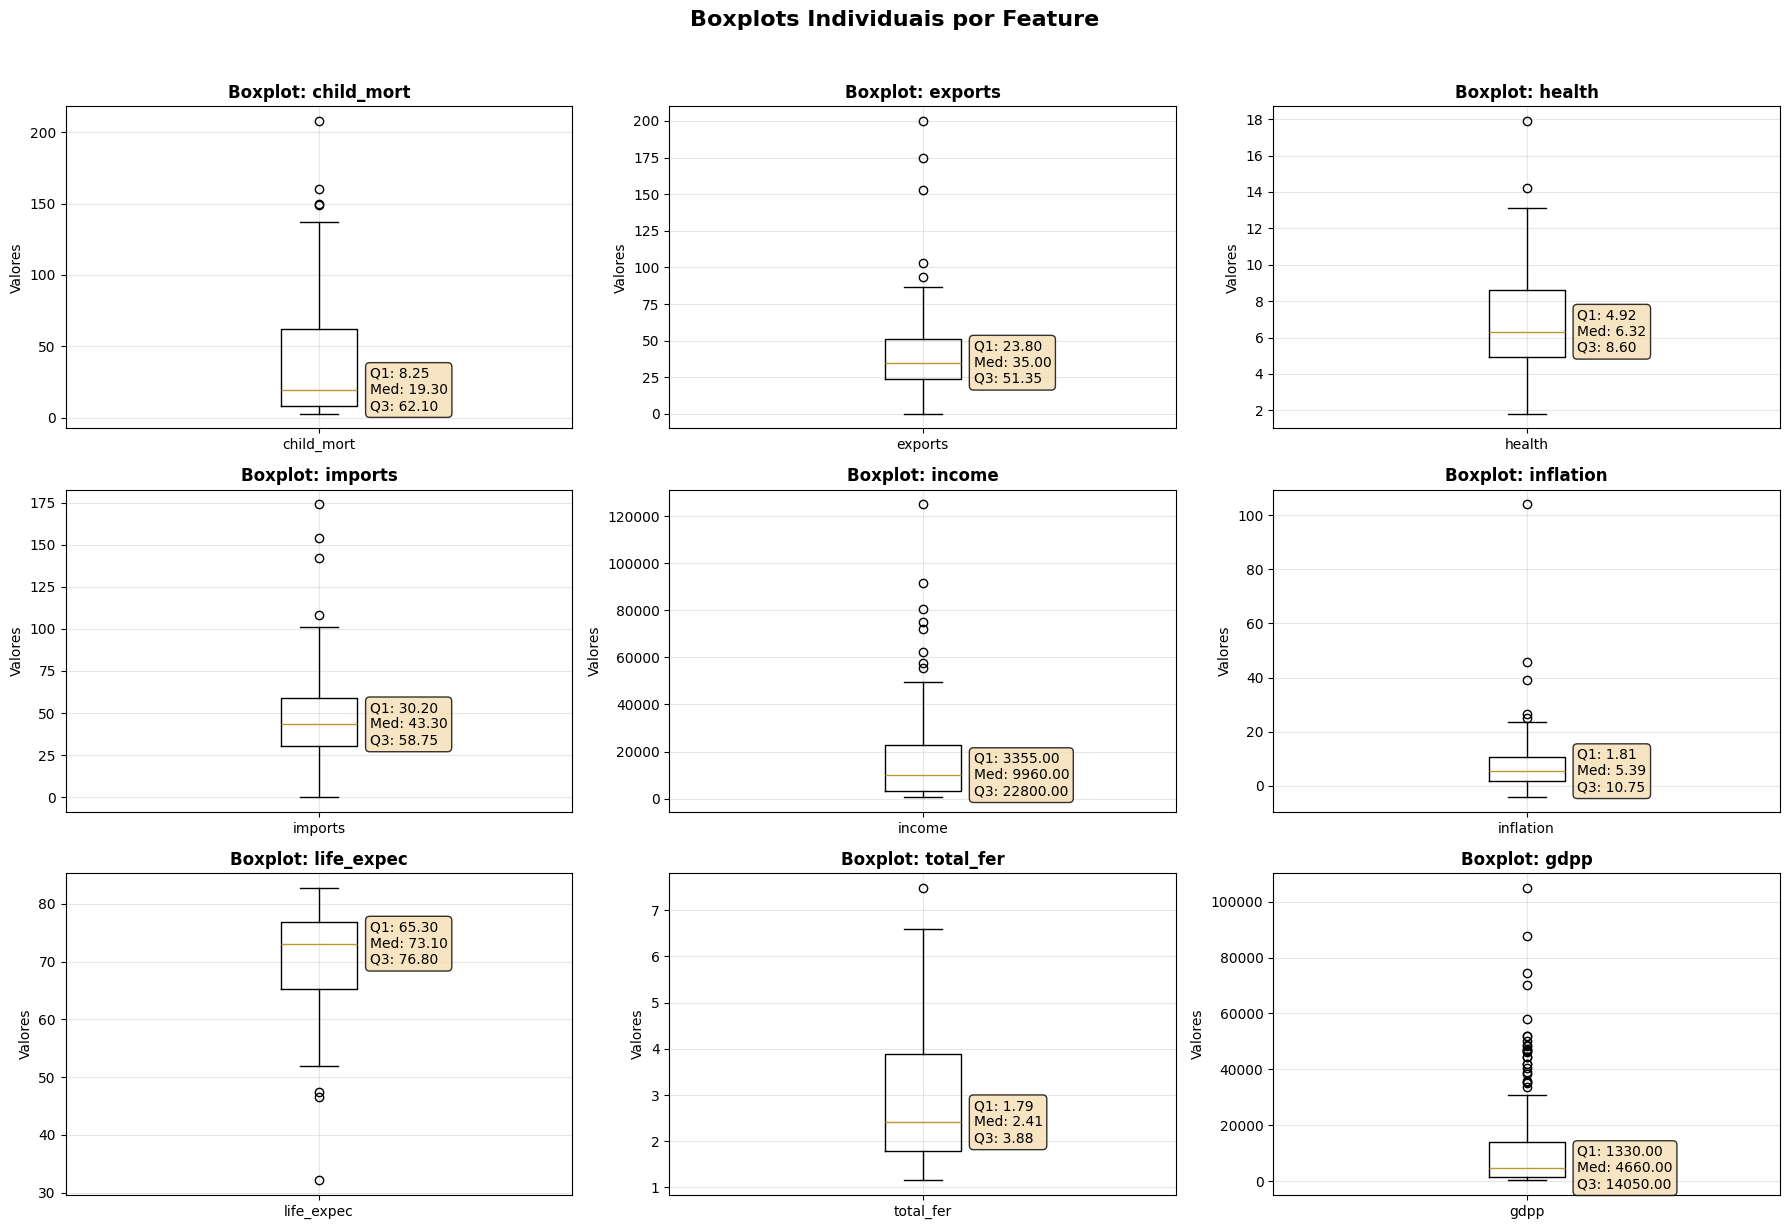

In [124]:
# Visualização: Boxplot individual para cada feature
n_cols = 3
n_rows = (len(dados_numericos.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, col in enumerate(dados_numericos.columns):
    axes[i].boxplot(dados_numericos[col], labels=[col])
    axes[i].set_title(f'Boxplot: {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valores', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Adicionar estatísticas na caixa
    q1 = dados_numericos[col].quantile(0.25)
    median = dados_numericos[col].median()
    q3 = dados_numericos[col].quantile(0.75)
    axes[i].text(1.1, median, f'Q1: {q1:.2f}\nMed: {median:.2f}\nQ3: {q3:.2f}', 
                 verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Remover eixos vazios se houver
for i in range(len(dados_numericos.columns), len(axes)):
    axes[i].remove()

plt.suptitle('Boxplots Individuais por Feature', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

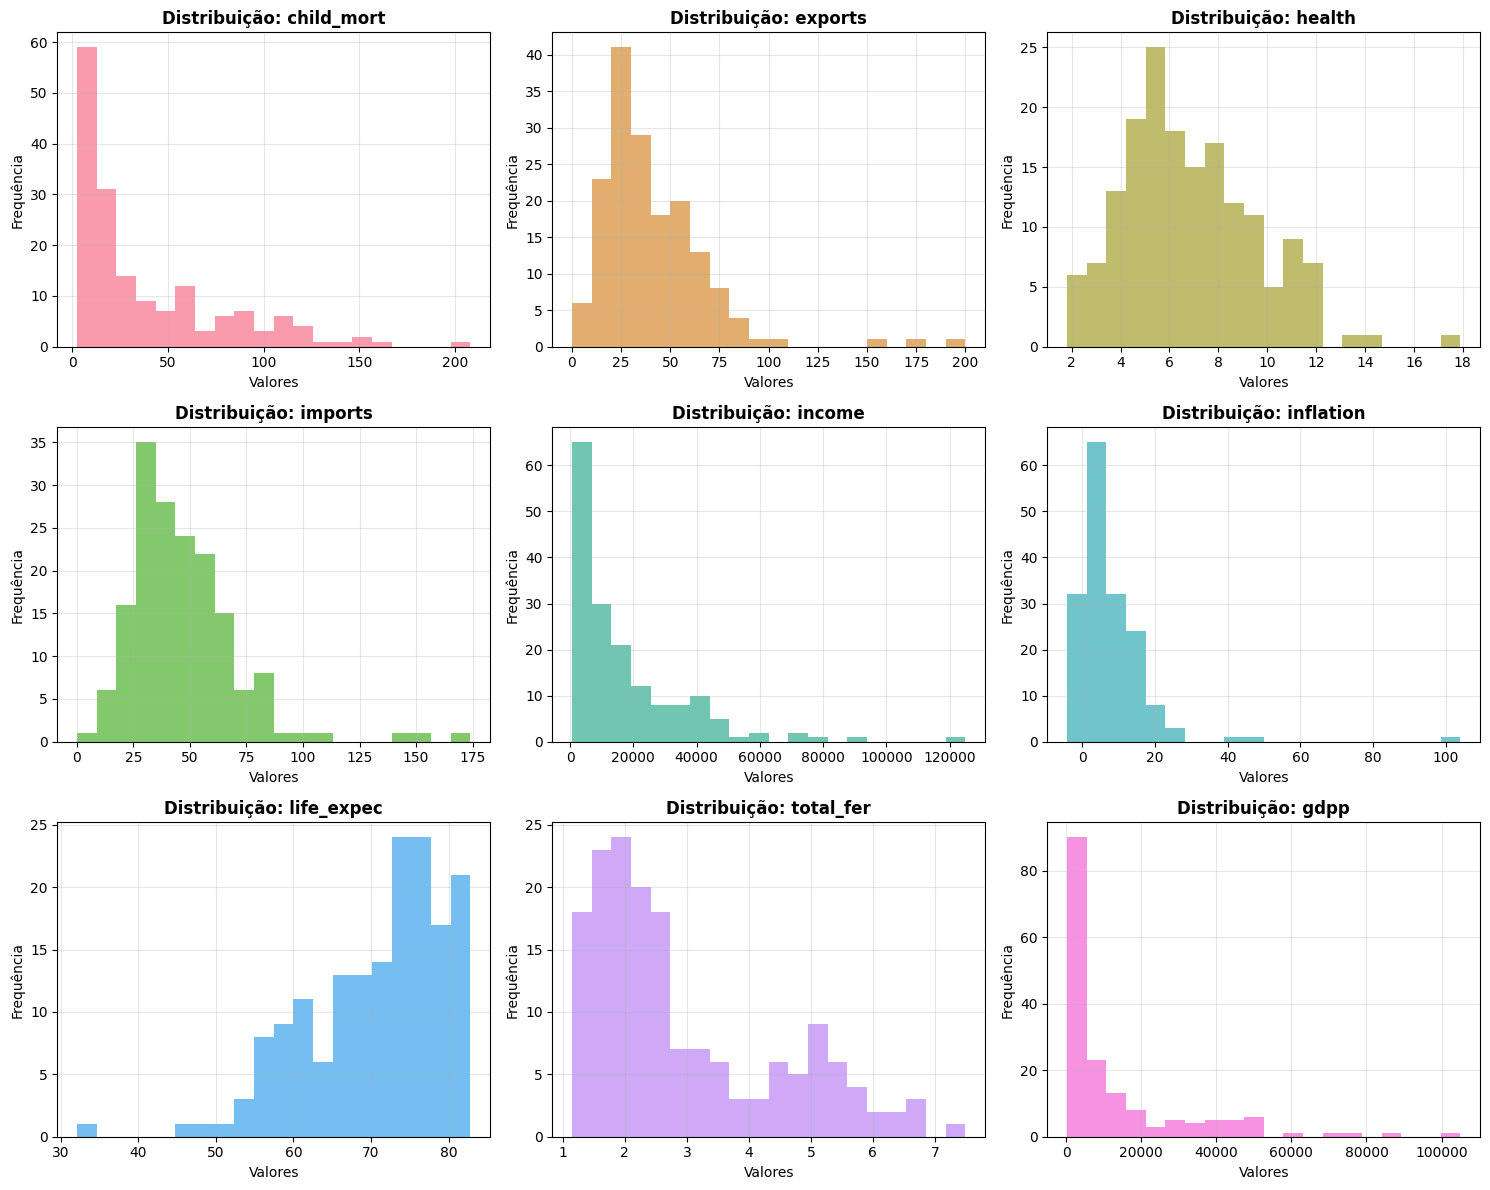

In [125]:
# Visualização 2: Histogramas das distribuições
n_cols = 3
n_rows = (len(dados_numericos.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, col in enumerate(dados_numericos.columns):
    axes[i].hist(dados_numericos[col], bins=20, alpha=0.7, color=sns.color_palette("husl", len(dados_numericos.columns))[i])
    axes[i].set_title(f'Distribuição: {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Valores', fontsize=10)
    axes[i].set_ylabel('Frequência', fontsize=10)
    axes[i].grid(True, alpha=0.3)

# Remover eixos vazios se houver
for i in range(len(dados_numericos.columns), len(axes)):
    axes[i].remove()

plt.tight_layout()
plt.show()

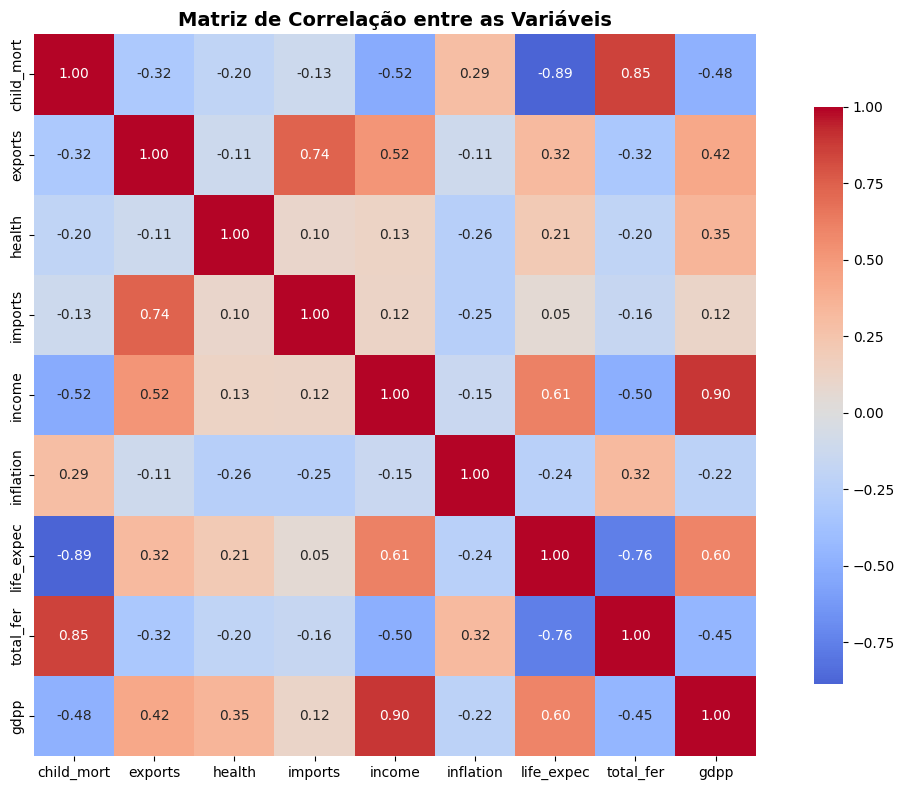

In [126]:
# Visualização 3: Heatmap de correlação
plt.figure(figsize=(12, 8))
correlation_matrix = dados_numericos.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação entre as Variáveis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [127]:
# Análise detalhada das correlações para redução de dimensionalidade
print("ANÁLISE DE CORRELAÇÕES PARA REDUÇÃO DE DIMENSIONALIDADE")
print("="*60)

# Encontrar correlações altas (acima de 0.7 ou abaixo de -0.7)
correlation_matrix = dados_numericos.corr()
high_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) >= 0.7:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            high_correlations.append({
                'var1': var1,
                'var2': var2,
                'correlation': correlation
            })

print("\n CORRELAÇÕES ALTAS (|r| >= 0.7):")
print("-" * 50)
if high_correlations:
    for corr in high_correlations:
        print(f"{corr['var1']:12} ↔ {corr['var2']:12} | r = {corr['correlation']:6.3f}")
else:
    print("Nenhuma correlação alta encontrada com critério |r| >= 0.7")

# Correlações moderadas (0.5 <= |r| < 0.7)
moderate_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if 0.5 <= abs(correlation) < 0.7:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            moderate_correlations.append({
                'var1': var1,
                'var2': var2,
                'correlation': correlation
            })

print(f"\n CORRELAÇÕES MODERADAS (0.5 ≤ |r| < 0.7):")
print("-" * 50)
if moderate_correlations:
    for corr in moderate_correlations:
        print(f"{corr['var1']:12} ↔ {corr['var2']:12} | r = {corr['correlation']:6.3f}")
else:
    print("Nenhuma correlação moderada encontrada.")

print("\n" + "="*60)

ANÁLISE DE CORRELAÇÕES PARA REDUÇÃO DE DIMENSIONALIDADE

 CORRELAÇÕES ALTAS (|r| >= 0.7):
--------------------------------------------------
child_mort   ↔ life_expec   | r = -0.887
child_mort   ↔ total_fer    | r =  0.848
exports      ↔ imports      | r =  0.737
income       ↔ gdpp         | r =  0.896
life_expec   ↔ total_fer    | r = -0.761

 CORRELAÇÕES MODERADAS (0.5 ≤ |r| < 0.7):
--------------------------------------------------
child_mort   ↔ income       | r = -0.524
exports      ↔ income       | r =  0.517
income       ↔ life_expec   | r =  0.612
income       ↔ total_fer    | r = -0.502
life_expec   ↔ gdpp         | r =  0.600



Considerando a análise das correlações poderiamos pensar em reduzir a dimensionalidade considerando o seguinte conjunto de features:

Exclusão de Features

- `income` com `gdpp` (r = 0.896)
1. Tratam de desenvolvimento econômico
2. Poderia-se escolher por manter apenas o `income`

- `child_mort` com `life_expec` (r = 0.848)
1. Tratam sobre saúde/mortalidade
2. Poderia-se escolher por manter apenas o `life_expec`

Combinação de Features
- `exports` com `imports` (r = 0.737)
1. Tratam de um assunto muito correlato
2. Poderia-se escolher por criar a variável combinada `trade_balance = exports - imports`

Entretanto, nessa clusterização serão utilizadas todas as features inicialmente.

# Pré-processamento dos Dados

In [128]:
# Verificação de valores ausentes e duplicatas
print("VERIFICAÇÃO DA QUALIDADE DOS DADOS")
print("="*50)

# Verificar valores ausentes
missing_values = dados_originais.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values)
print(f"\nTotal de valores ausentes: {missing_values.sum()}")

# Verificar duplicatas
duplicates = dados_originais.duplicated().sum()
print(f"Linhas duplicadas: {duplicates}")

# Verificar duplicatas na coluna 'country' (se houver países repetidos)
country_duplicates = dados_originais['country'].duplicated().sum()
print(f"Países duplicados: {country_duplicates}")

print("\n" + "="*50)

VERIFICAÇÃO DA QUALIDADE DOS DADOS
Valores ausentes por coluna:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Total de valores ausentes: 0
Linhas duplicadas: 0
Países duplicados: 0



In [129]:
 # Identificação e análise de outliers
from scipy import stats

print("IDENTIFICAÇÃO DE OUTLIERS")
print("="*50)

# Função para identificar outliers usando IQR
def identify_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Identificar outliers para cada variável numérica
outliers_summary = {}
for col in dados_numericos.columns:
    outliers, lower, upper = identify_outliers_iqr(dados_numericos, col)
    outliers_summary[col] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(dados_numericos)) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }
    print(f"{col:15} | Outliers: {len(outliers):3d} ({(len(outliers)/len(dados_numericos)*100):5.1f}%)")

print("\n" + "="*50)

IDENTIFICAÇÃO DE OUTLIERS
child_mort      | Outliers:   4 (  2.4%)
exports         | Outliers:   5 (  3.0%)
health          | Outliers:   2 (  1.2%)
imports         | Outliers:   4 (  2.4%)
income          | Outliers:   8 (  4.8%)
inflation       | Outliers:   5 (  3.0%)
life_expec      | Outliers:   3 (  1.8%)
total_fer       | Outliers:   1 (  0.6%)
gdpp            | Outliers:  25 ( 15.0%)



In [130]:
 # Normalização dos dados
print("NORMALIZAÇÃO DOS DADOS")
print("="*50)

# Criar diferentes versões normalizadas para comparação
# 1. StandardScaler (Z-score normalization)
scaler_standard = StandardScaler()
dados_standard = scaler_standard.fit_transform(dados_numericos)
dados_standard_df = pd.DataFrame(dados_standard, columns=dados_numericos.columns, index=dados_numericos.index)
dados_standard_df.index = dados_originais['country']


print("Normalização StandardScaler aplicada")

# Mostrar estatísticas dos dados normalizados
print("\nEstatísticas dos dados após StandardScaler:")
print("Média:", dados_standard_df.mean().round(3).tolist())
print("Desvio padrão:", dados_standard_df.std().round(3).tolist())

print("\n" + "="*50)

NORMALIZAÇÃO DOS DADOS
Normalização StandardScaler aplicada

Estatísticas dos dados após StandardScaler:
Média: [-0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0]
Desvio padrão: [1.003, 1.003, 1.003, 1.003, 1.003, 1.003, 1.003, 1.003, 1.003]



# Clusterização

In [131]:
print("PREPARAÇÃO PARA CLUSTERIZAÇÃO COMPARATIVA")
print("="*60)

# Organizar os datasets para análise
datasets = {
    'Original (9 var)': dados_standard_df,
}

print(" DATASETS PREPARADOS PARA CLUSTERIZAÇÃO:")
for nome, dataset in datasets.items():
    print(f"   {nome:15} | Shape: {dataset.shape} | Variáveis: {list(dataset.columns)}")

print(f"\n ALGORITMOS A SEREM APLICADOS:")
print(f"   • K-Means (k=3)")
print(f"   • Clusterização Hierárquica (n_clusters=3)")

print(f"\n MÉTRICAS DE AVALIAÇÃO:")
print(f"   • Análise de centroides (K-means)")
print(f"   • Dendrogramas (Hierárquica)")
print(f"   • Silhouette Score")
print(f"   • Inércia (K-means)")

print("\n" + "="*60)

PREPARAÇÃO PARA CLUSTERIZAÇÃO COMPARATIVA
 DATASETS PREPARADOS PARA CLUSTERIZAÇÃO:
   Original (9 var) | Shape: (167, 9) | Variáveis: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

 ALGORITMOS A SEREM APLICADOS:
   • K-Means (k=3)
   • Clusterização Hierárquica (n_clusters=3)

 MÉTRICAS DE AVALIAÇÃO:
   • Análise de centroides (K-means)
   • Dendrogramas (Hierárquica)
   • Silhouette Score
   • Inércia (K-means)



## Implementação do K-Means (k=3)

In [132]:
# Aplicação do K-Means com k=3
print("K-MEANS (k=3)")
print("="*65)

# Dicionário para armazenar resultados
resultados_kmeans = {}

# Aplicar K-means 
for nome, dataset in datasets.items():
    print(f"\n Aplicando K-Means em {nome}:")
    
    # Configurar K-means
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
    
    # Ajustar e predizer
    clusters_kmeans = kmeans.fit_predict(dataset)
    
    # Calcular métricas
    silhouette = silhouette_score(dataset, clusters_kmeans)
    inertia = kmeans.inertia_
    
    # Adicionar clusters ao dataset
    dataset_com_clusters = dataset.copy()
    dataset_com_clusters['Cluster_KMeans'] = clusters_kmeans
    
    # Armazenar resultados
    resultados_kmeans[nome] = {
        'modelo': kmeans,
        'clusters': clusters_kmeans,
        'dataset_com_clusters': dataset_com_clusters,
        'silhouette_score': silhouette,
        'inertia': inertia,
        'centroids': kmeans.cluster_centers_
    }
    
    # Contar países por cluster
    cluster_counts = pd.Series(clusters_kmeans).value_counts().sort_index()
    
    print(f"    Clusters criados:")
    for cluster_id, count in cluster_counts.items():
        print(f"      Cluster {cluster_id}: {count} países")
    
    print(f"    Silhouette Score: {silhouette:.3f}")
    print(f"    Inércia: {inertia:.2f}")

# Resumo comparativo
print(f"\n RESUMO - K-MEANS:")
print("-" * 50)
for nome, resultado in resultados_kmeans.items():
    print(f"{nome:15} | Silhouette: {resultado['silhouette_score']:.3f} | Inércia: {resultado['inertia']:.2f}")

print("\n" + "="*65)

K-MEANS (k=3)

 Aplicando K-Means em Original (9 var):


    Clusters criados:
      Cluster 0: 36 países
      Cluster 1: 47 países
      Cluster 2: 84 países
    Silhouette Score: 0.283
    Inércia: 831.42

 RESUMO - K-MEANS:
--------------------------------------------------
Original (9 var) | Silhouette: 0.283 | Inércia: 831.42



## Interpretação dos Clusters do K-Means

In [133]:
# Análise dos centroides e distribuição das dimensões por cluster
print("INTERPRETAÇÃO DOS CLUSTERS DO K-MEANS")
print("="*60)

def analisar_clusters_kmeans(nome_dataset, resultado_kmeans):
    """Análise detalhada dos clusters do K-means"""
    
    dataset_com_clusters = resultado_kmeans['dataset_com_clusters']
    centroids = resultado_kmeans['centroids']
    
    # Distribuição das dimensões em cada grupo
    print(f"\n DISTRIBUIÇÃO DAS DIMENSÕES POR CLUSTER:")
    print("-" * 40)
    
    for cluster_id in range(3):
        cluster_data = dataset_com_clusters[dataset_com_clusters['Cluster_KMeans'] == cluster_id]
        n_paises = len(cluster_data)
        
        print(f"\n CLUSTER {cluster_id} ({n_paises} países):")
        
        # Estatísticas por dimensão (excluindo coluna de cluster)
        features = [col for col in cluster_data.columns if col != 'Cluster_KMeans']
        
        for i, feature in enumerate(features):
            centroid_val = centroids[cluster_id][i]
            cluster_mean = cluster_data[feature].mean()
            cluster_std = cluster_data[feature].std()
            
            print(f"   {feature:15} | Centroide: {centroid_val:6.3f} | Média: {cluster_mean:6.3f} | Std: {cluster_std:6.3f}")
        

        # Listar países do cluster
        paises_cluster = cluster_data.index.tolist()
        n_paises = len(paises_cluster)

        print(f"    Países ({n_paises}):")

        # imprime 7 países por linha
        for i in range(0, n_paises, 7):
            grupo = paises_cluster[i:i+7]
            print("        " + ", ".join(grupo))

    
    return dataset_com_clusters

# Analisar cada dataset
for nome, resultado in resultados_kmeans.items():
    clusters_com_dados = analisar_clusters_kmeans(nome, resultado)
    
    # Armazenar para uso posterior
    resultados_kmeans[nome]['dataset_detalhado'] = clusters_com_dados

print("\n" + "="*60)

INTERPRETAÇÃO DOS CLUSTERS DO K-MEANS

 DISTRIBUIÇÃO DAS DIMENSÕES POR CLUSTER:
----------------------------------------

 CLUSTER 0 (36 países):
   child_mort      | Centroide: -0.827 | Média: -0.827 | Std:  0.054
   exports         | Centroide:  0.645 | Média:  0.645 | Std:  1.534
   health          | Centroide:  0.727 | Média:  0.727 | Std:  1.160
   imports         | Centroide:  0.191 | Média:  0.191 | Std:  1.526
   income          | Centroide:  1.484 | Média:  1.484 | Std:  1.085
   inflation       | Centroide: -0.485 | Média: -0.485 | Std:  0.387
   life_expec      | Centroide:  1.080 | Média:  1.080 | Std:  0.205
   total_fer       | Centroide: -0.792 | Média: -0.792 | Std:  0.247
   gdpp            | Centroide:  1.616 | Média:  1.616 | Std:  1.039
    Países (36):
        Australia, Austria, Bahrain, Belgium, Brunei, Canada, Cyprus
        Czech Republic, Denmark, Finland, France, Germany, Greece, Iceland
        Ireland, Israel, Italy, Japan, Kuwait, Luxembourg, Malta
       

## Países mais representativos de cada cluster

In [134]:
# Identificação do país mais representativo de cada cluster
print("PAÍSES MAIS REPRESENTATIVOS DE CADA CLUSTER")
print("="*65)

def encontrar_pais_mais_representativo(nome_dataset, resultado_kmeans):
    """Encontra o país mais próximo do centroide de cada cluster"""
    
    print(f"\n PAÍSES REPRESENTATIVOS - {nome_dataset.upper()}")
    print("-" * 50)
    
    dataset_com_clusters = resultado_kmeans['dataset_detalhado']
    centroids = resultado_kmeans['centroids']
    
    representativos = {}
    
    for cluster_id in range(3):
        cluster_data = dataset_com_clusters[dataset_com_clusters['Cluster_KMeans'] == cluster_id]
        
        # Remover coluna de cluster para cálculo de distância
        cluster_features = cluster_data.drop('Cluster_KMeans', axis=1)
        
        # Calcular distâncias euclidianas do centroide
        centroid = centroids[cluster_id]
        distancias = []
        
        for idx, row in cluster_features.iterrows():
            distancia = np.sqrt(np.sum((row.values - centroid) ** 2))
            distancias.append((idx, distancia))
        
        # Encontrar o país mais próximo (menor distância)
        pais_mais_proximo = min(distancias, key=lambda x: x[1])
        pais_nome = pais_mais_proximo[0]
        distancia_min = pais_mais_proximo[1]
        
        # Dados do país representativo
        dados_pais = cluster_features.loc[pais_nome]
        
        representativos[cluster_id] = {
            'pais': pais_nome,
            'distancia': distancia_min,
            'dados': dados_pais
        }
        
        print(f"\n CLUSTER {cluster_id} - País Representativo: {pais_nome}")
        print(f"    Distância do centroide: {distancia_min:.3f}")
        print(f"    Características do país:")
        
        for feature, valor in dados_pais.items():
            centroid_val = centroids[cluster_id][list(cluster_features.columns).index(feature)]
            diferenca = abs(valor - centroid_val)
            print(f"      {feature:15} | País: {valor:6.3f} | Centroide: {centroid_val:6.3f} | Diff: {diferenca:.3f}")
        
        print(f"    Justificativa: {pais_nome} é o país mais próximo do centroide do cluster {cluster_id},")
        print(f"      representando melhor as características médias deste grupo.")
    
    return representativos

# Encontrar países representativos para cada dataset
paises_representativos = {}
for nome, resultado in resultados_kmeans.items():
    paises_representativos[nome] = encontrar_pais_mais_representativo(nome, resultado)

print("\n" + "="*65)

PAÍSES MAIS REPRESENTATIVOS DE CADA CLUSTER

 PAÍSES REPRESENTATIVOS - ORIGINAL (9 VAR)
--------------------------------------------------

 CLUSTER 0 - País Representativo: Iceland
    Distância do centroide: 0.732
    Características do país:
      child_mort      | País: -0.887 | Centroide: -0.827 | Diff: 0.060
      exports         | País:  0.450 | Centroide:  0.645 | Diff: 0.195
      health          | País:  0.944 | Centroide:  0.727 | Diff: 0.216
      imports         | País: -0.149 | Centroide:  0.191 | Diff: 0.339
      income          | País:  1.127 | Centroide:  1.484 | Diff: 0.358
      inflation       | País: -0.219 | Centroide: -0.485 | Diff: 0.266
      life_expec      | País:  1.291 | Centroide:  1.080 | Diff: 0.211
      total_fer       | País: -0.496 | Centroide: -0.792 | Diff: 0.296
      gdpp            | País:  1.583 | Centroide:  1.616 | Diff: 0.033
    Justificativa: Iceland é o país mais próximo do centroide do cluster 0,
      representando melhor as caracterís

## Clusterização Hierárquica

In [135]:
# Aplicação da Clusterização Hierárquica com n_clusters=3
print(" CLUSTERIZAÇÃO HIERÁRQUICA (n_clusters=3)")
print("="*75)

# Dicionário para armazenar resultados hierárquicos
resultados_hierarquico = {}

# Aplicar Clusterização Hierárquica em cada dataset
for nome, dataset in datasets.items():
    print(f"\n Aplicando Clusterização Hierárquica em {nome}:")
    
    # Configurar Clusterização Hierárquica (Ward linkage)
    hierarquico = AgglomerativeClustering(n_clusters=3, linkage='ward')
    
    # Ajustar e predizer
    clusters_hierarquico = hierarquico.fit_predict(dataset)
    
    # Calcular métricas
    silhouette_hier = silhouette_score(dataset, clusters_hierarquico)
    
    # Adicionar clusters ao dataset
    dataset_com_clusters_hier = dataset.copy()
    dataset_com_clusters_hier['Cluster_Hierarquico'] = clusters_hierarquico
    
    # Calcular linkage matrix para dendrograma
    linkage_matrix = linkage(dataset, method='ward')
    
    # Armazenar resultados
    resultados_hierarquico[nome] = {
        'modelo': hierarquico,
        'clusters': clusters_hierarquico,
        'dataset_com_clusters': dataset_com_clusters_hier,
        'silhouette_score': silhouette_hier,
        'linkage_matrix': linkage_matrix
    }
    
    # Contar países por cluster
    cluster_counts_hier = pd.Series(clusters_hierarquico).value_counts().sort_index()
    
    print(f"    Clusters criados:")
    for cluster_id, count in cluster_counts_hier.items():
        print(f"      Cluster {cluster_id}: {count} países")
    
    print(f"    Silhouette Score: {silhouette_hier:.3f}")

# Resumo comparativo
print(f"\n RESUMO - CLUSTERIZAÇÃO HIERÁRQUICA:")
print("-" * 50)
for nome, resultado in resultados_hierarquico.items():
    print(f"{nome:15} | Silhouette: {resultado['silhouette_score']:.3f}")


 CLUSTERIZAÇÃO HIERÁRQUICA (n_clusters=3)

 Aplicando Clusterização Hierárquica em Original (9 var):
    Clusters criados:
      Cluster 0: 34 países
      Cluster 1: 106 países
      Cluster 2: 27 países
    Silhouette Score: 0.246

 RESUMO - CLUSTERIZAÇÃO HIERÁRQUICA:
--------------------------------------------------
Original (9 var) | Silhouette: 0.246


## Dendogramas da Clusterização Hierarquica

3. DENDROGRAMAS E INTERPRETAÇÃO - CLUSTERIZAÇÃO HIERÁRQUICA
📏 Original (9 var): Altura de corte visual para 3 clusters = 18.5083


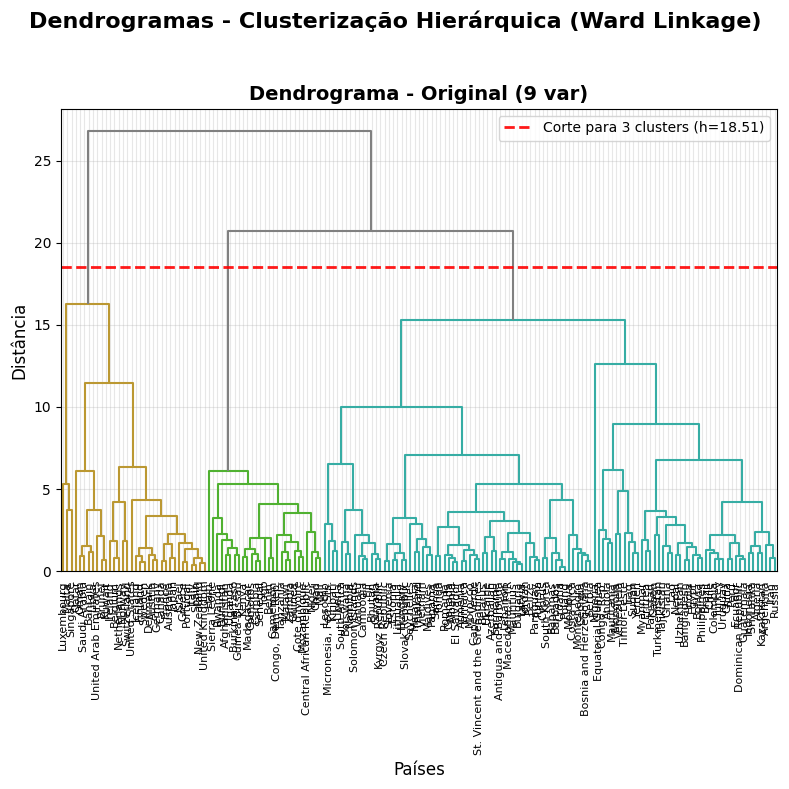


 INTERPRETAÇÃO DOS DENDROGRAMAS:
--------------------------------------------------
    Silhouette Score: 0.246
    Cluster 1: 34 países
        Australia, Austria, Bahrain, Belgium, Brunei, Canada, Denmark
        Finland, France, Germany, Greece, Iceland, Ireland, Israel
        Italy, Japan, Kuwait, Libya, Luxembourg, Malta, Netherlands
        New Zealand, Norway, Oman, Portugal, Qatar, Saudi Arabia, Singapore
        Spain, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States
    Cluster 2: 27 países
        Afghanistan, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad
        Comoros, Congo, Dem. Rep., Cote d'Ivoire, Gambia, Guinea, Guinea-Bissau, Haiti
        Kenya, Madagascar, Malawi, Mali, Mozambique, Niger, Rwanda
        Senegal, Sierra Leone, Tanzania, Togo, Uganda, Zambia
    Cluster 3: 106 países
        Albania, Algeria, Angola, Antigua and Barbuda, Argentina, Armenia, Azerbaijan
        Bahamas, Bangladesh, Barbados, Belarus, 

In [136]:

# 3. DENDROGRAMAS E INTERPRETAÇÃO - CLUSTERIZAÇÃO HIERÁRQUICA
print("3. DENDROGRAMAS E INTERPRETAÇÃO - CLUSTERIZAÇÃO HIERÁRQUICA")
print("="*70)

# Função para obter a altura de corte que MOSTRA exatamente k clusters ---
def altura_corte_para_k_clusters(linkage_matrix, k: int):

    h_lower = float(linkage_matrix[-k, 2])      # terceira maior fusão quando k=3
    h_upper = float(linkage_matrix[-(k-1), 2])  # segunda maior fusão quando k=3

    # Se houver empate de alturas, empurra um epsilon para baixo do limite superior
    if h_upper <= h_lower:
        return h_lower - 1e-6
    # Qualquer valor no intervalo (h_lower, h_upper) gera k clusters; use o meio para estabilidade
    return (h_lower + h_upper) / 2.0

# --- Plot do dendrograma (dinâmico: 1..N gráficos)
n_plots = len(resultados_hierarquico)
if n_plots == 0:
    raise ValueError("resultados_hierarquico está vazio.")

fig, axes = plt.subplots(
    1, n_plots,
    figsize=(8 * n_plots, 8),
    squeeze=False   # <- garante matriz 2D mesmo com 1 gráfico
)
axes = axes.ravel()  # <- vira array 1D; axes[i] funciona com n_plots=1

interpretacoes_hierarchical = {}

for i, (nome, resultado) in enumerate(resultados_hierarquico.items()):
    Z = resultado['linkage_matrix']
    dataset = datasets[nome]

    h_cut = altura_corte_para_k_clusters(Z, k=3)
    print(f"📏 {nome}: Altura de corte visual para 3 clusters = {h_cut:.4f}")

    dendro = dendrogram(
        Z,
        ax=axes[i],
        labels=dataset.index.tolist(),
        leaf_rotation=90,
        leaf_font_size=8,
        show_leaf_counts=False,
        color_threshold=h_cut,
        above_threshold_color='gray'
    )

    ax = axes[i]
    ax.set_title(f'Dendrograma - {nome}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Países', fontsize=12)
    ax.set_ylabel('Distância', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=h_cut, color='red', linestyle='--', alpha=0.9, linewidth=2,
               label=f'Corte para 3 clusters (h={h_cut:.2f})')
    ax.legend()

plt.suptitle('Dendrogramas - Clusterização Hierárquica (Ward Linkage)',
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


# Interpretação (mantida, mas usando clusters_max para garantir 3 grupos)
print(f"\n INTERPRETAÇÃO DOS DENDROGRAMAS:")
print("-" * 50)

for nome, resultado in resultados_hierarquico.items():
    dataset_com_clusters = resultado['dataset_com_clusters']

    # use maxclust para garantir 3 grupos na análise textual
    clusters_hier = fcluster(Z, 3, criterion='maxclust')

    print(f"    Silhouette Score: {resultado['silhouette_score']:.3f}")

    # Análise dos 3 clusters
    for cluster_id in sorted(np.unique(clusters_hier)):
        mask = (clusters_hier == cluster_id)
        paises = dataset_com_clusters.index[mask].tolist()
        n_paises = len(paises)
        print(f"    Cluster {cluster_id}: {n_paises} países")

        # Listar países do cluster
        # imprime 7 países por linha
        for i in range(0, n_paises, 7):
            grupo = paises[i:i+7]
            print("        " + ", ".join(grupo))

print("\n" + "="*70)


# Comparação entre o K-Means e o Hierarquico

In [137]:
# Comparação entre métodos
print(f"\n COMPARAÇÃO ENTRE K-MEANS E HIERÁRQUICA:")
print("-" * 50)
for nome in datasets.keys():
    kmeans_sil = resultados_kmeans[nome]['silhouette_score']
    hier_sil = resultados_hierarquico[nome]['silhouette_score']
    melhor = "K-Means" if kmeans_sil > hier_sil else "Hierárquica"
    print(f"{nome:15} | K-Means: {kmeans_sil:.3f} | Hierárquica: {hier_sil:.3f} | Melhor: {melhor}")

print("\n" + "="*75)


 COMPARAÇÃO ENTRE K-MEANS E HIERÁRQUICA:
--------------------------------------------------
Original (9 var) | K-Means: 0.283 | Hierárquica: 0.246 | Melhor: K-Means



## Visualização comparativa dos Clusters

VISUALIZAÇÃO COMPARATIVA DOS CLUSTERS


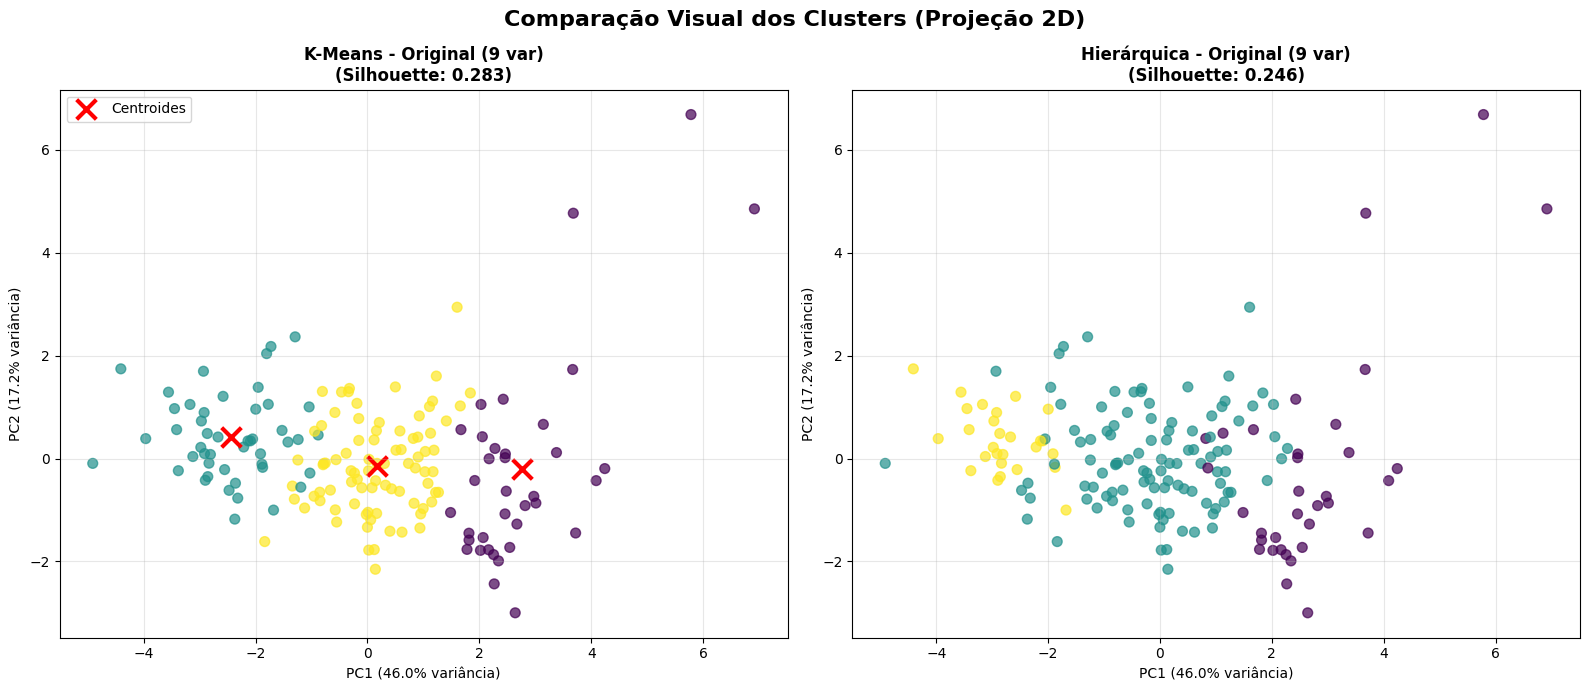

In [138]:
# Visualização: 2 gráficos
print("VISUALIZAÇÃO COMPARATIVA DOS CLUSTERS")
print("="*50)

nome, dataset = list(datasets.items())[0]

# PCA 2D apenas para visualização
pca_vis = PCA(n_components=2, random_state=42)
dados_2d = pca_vis.fit_transform(dataset)
pc1_var = pca_vis.explained_variance_ratio_[0]
pc2_var = pca_vis.explained_variance_ratio_[1]

# Cria figura com 1 linha e 2 colunas (axes é 1-D)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico 1: K-Means

ax_km = axes[0]
clusters_km = resultados_kmeans[nome]['clusters']
ax_km.scatter(dados_2d[:, 0], dados_2d[:, 1],
              c=clusters_km, cmap='viridis', alpha=0.7, s=50)

# Centroides projetados em 2D (se necessário)
centroids = resultados_kmeans[nome]['centroids']
centroids_2d = pca_vis.transform(centroids) if centroids.shape[1] > 2 else centroids
ax_km.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
              c='red', marker='x', s=200, linewidths=3, label='Centroides')
ax_km.legend()

ax_km.set_title(
    f'K-Means - {nome}\n(Silhouette: {resultados_kmeans[nome]["silhouette_score"]:.3f})',
    fontsize=12, fontweight='bold'
)
ax_km.set_xlabel(f'PC1 ({pc1_var:.1%} variância)')
ax_km.set_ylabel(f'PC2 ({pc2_var:.1%} variância)')
ax_km.grid(True, alpha=0.3)

# Gráfico 2: Hierárquica

ax_h = axes[1]
clusters_hier = resultados_hierarquico[nome]['clusters']
ax_h.scatter(dados_2d[:, 0], dados_2d[:, 1],
             c=clusters_hier, cmap='viridis', alpha=0.7, s=50)

ax_h.set_title(
    f'Hierárquica - {nome}\n(Silhouette: {resultados_hierarquico[nome]["silhouette_score"]:.3f})',
    fontsize=12, fontweight='bold'
)
ax_h.set_xlabel(f'PC1 ({pc1_var:.1%} variância)')
ax_h.set_ylabel(f'PC2 ({pc2_var:.1%} variância)')
ax_h.grid(True, alpha=0.3)

plt.suptitle('Comparação Visual dos Clusters (Projeção 2D)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
